In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import bisect
from sklearn.preprocessing import LabelEncoder

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False
plt.rcParams['figure.figsize'] = (10,10)

sns.set(font="Malgun Gothic", 
        rc={"axes.unicode_minus":False}, # 마이너스 부호 깨짐 현상 해결
        style='whitegrid')

In [2]:
train = pd.read_csv('./data/train.csv')
df= train.copy()
df.shape

(391939, 23)

In [3]:
col_dic = {'ARI_CO':'도착국가',
            'ARI_PO':'도착항구명',
            'SHIP_TYPE_CATEGORY':'5대 선종으로 분류',
            'DIST':'정박지와 접안지 거리(km)',
            'ATA':'실제 정박 시각(H)',
            'ID':'선박식별 일련번호',
            'BREADTH':'선박 폭(m)',
            'BUILT':'선박 연령',
            'DEADWEIGHT':'선박 재화중량톤수(t)',
            'DEPTH':'선박 깊이(m)',
            'DRAUGHT':'흘수 높이(m)',
            'GT':'용적톤수 값',
            'LENGTH':'선박 길이(m)',
            'SHIPMANAGER':'선박 소유주',
            'FLAG':'선박 국적',
            'U_WIND':'풍향 u벡터(m/s)',
            'V_WIND':'풍향 v벡터(m/s)',
            'AIR_TEMPERATURE':'기온(C)',
            'BN':'보퍼트 풍력 계급',
            'ATA_LT':'현지 정박 시각(H)',
            'DUBAI':'해당일의 두바이유 값($)',
            'BRENT':'해당일의 브렌트유 값($)',
            'WTI':'해당일의 WTI 값($)',
            'BDI_ADJ':'조정된 벌크운임지수',
            'PORT_SIZE':'접안지 폴리곤 영역의 크기',
            'CI_HOUR':'대기시간(h)'}

In [4]:
df = df.rename(columns=col_dic)
df.head(1)

,SAMPLE_ID,도착국가,도착항구명,5대 선종으로 분류,정박지와 접안지 거리(km),실제 정박 시각(H),선박식별 일련번호,선박 폭(m),선박 연령,선박 재화중량톤수(t),...,선박 길이(m),선박 소유주,선박 국적,풍향 u벡터(m/s),풍향 v벡터(m/s),기온(C),보퍼트 풍력 계급,현지 정박 시각(H),접안지 폴리곤 영역의 크기,대기시간(h)
0,TRAIN_000000,SG,GIW5,Container,30.881018,2018-12-17 21:29,Z618338,30.0,24,24300,...,180.0,CQSB78,Panama,NaN,NaN,NaN,NaN,5,0.002615,3.45


In [5]:
df = df[df.도착항구명 != 'RGT8']
df.shape

(391933, 23)

In [6]:
df.loc[df['도착항구명']=='RGT8']

,SAMPLE_ID,도착국가,도착항구명,5대 선종으로 분류,정박지와 접안지 거리(km),실제 정박 시각(H),선박식별 일련번호,선박 폭(m),선박 연령,선박 재화중량톤수(t),...,선박 길이(m),선박 소유주,선박 국적,풍향 u벡터(m/s),풍향 v벡터(m/s),기온(C),보퍼트 풍력 계급,현지 정박 시각(H),접안지 폴리곤 영역의 크기,대기시간(h)


In [7]:
df.isnull().sum()

SAMPLE_ID               0
도착국가                    0
도착항구명                   0
5대 선종으로 분류              0
정박지와 접안지 거리(km)         0
실제 정박 시각(H)             0
선박식별 일련번호               0
선박 폭(m)                 1
선박 연령                   0
선박 재화중량톤수(t)            0
선박 깊이(m)                1
흘수 높이(m)                1
용적톤수 값                  0
선박 길이(m)                1
선박 소유주                  0
선박 국적                   0
풍향 u벡터(m/s)        163682
풍향 v벡터(m/s)        163682
기온(C)              164624
보퍼트 풍력 계급          163682
현지 정박 시각(H)             0
접안지 폴리곤 영역의 크기          0
대기시간(h)                 0
dtype: int64

In [8]:
df.columns

Index(['SAMPLE_ID', '도착국가', '도착항구명', '5대 선종으로 분류', '정박지와 접안지 거리(km)',
       '실제 정박 시각(H)', '선박식별 일련번호', '선박 폭(m)', '선박 연령', '선박 재화중량톤수(t)',
       '선박 깊이(m)', '흘수 높이(m)', '용적톤수 값', '선박 길이(m)', '선박 소유주', '선박 국적',
       '풍향 u벡터(m/s)', '풍향 v벡터(m/s)', '기온(C)', '보퍼트 풍력 계급', '현지 정박 시각(H)',
       '접안지 폴리곤 영역의 크기', '대기시간(h)'],
      dtype='object')

In [9]:
df_port_temp = df.groupby(['도착항구명'])['기온(C)'].mean().to_dict()

for port, mean_temp in df_port_temp.items():
    df.loc[df['도착항구명'] == port, '기온(C)'] = df.loc[df['도착항구명'] == port, '기온(C)'].fillna(mean_temp)
    

df['기온(C)'].isnull().sum()

0

In [10]:
len(df['도착항구명'].unique())

102

In [11]:
df_port_v = df.groupby(['도착항구명'])['풍향 v벡터(m/s)'].mean().to_dict()

for port, mean_temp in df_port_v.items():
    df.loc[df['도착항구명'] == port, '풍향 v벡터(m/s)'] = df.loc[df['도착항구명'] == port, '풍향 v벡터(m/s)'].fillna(mean_temp)
    
df['풍향 v벡터(m/s)'].isnull().sum()

0

In [12]:
df_port_u = df.groupby(['도착항구명'])['풍향 u벡터(m/s)'].mean().to_dict()
for port, mean_temp in df_port_u.items():
    df.loc[df['도착항구명'] == port, '풍향 u벡터(m/s)'] = df.loc[df['도착항구명'] == port, '풍향 u벡터(m/s)'].fillna(mean_temp)
    
df['풍향 u벡터(m/s)'].isnull().sum()

0

In [13]:
df_port_class = df.groupby(['도착항구명'])['보퍼트 풍력 계급'].mean().to_dict()
for port, mean_temp in df_port_class.items():
    df.loc[df['도착항구명'] == port, '보퍼트 풍력 계급'] = df.loc[df['도착항구명'] == port, '보퍼트 풍력 계급'].fillna(mean_temp)
    
df['보퍼트 풍력 계급'].isnull().sum()
df

,SAMPLE_ID,도착국가,도착항구명,5대 선종으로 분류,정박지와 접안지 거리(km),실제 정박 시각(H),선박식별 일련번호,선박 폭(m),선박 연령,선박 재화중량톤수(t),...,선박 길이(m),선박 소유주,선박 국적,풍향 u벡터(m/s),풍향 v벡터(m/s),기온(C),보퍼트 풍력 계급,현지 정박 시각(H),접안지 폴리곤 영역의 크기,대기시간(h)
0,TRAIN_000000,SG,GIW5,Container,30.881018,2018-12-17 21:29,Z618338,30.0,24,24300,...,180.0,CQSB78,Panama,-0.56,0.00,27.2,2.097913,5,0.002615,3.450000
1,TRAIN_000001,IN,UJM2,Bulk,0.000000,2014-09-23 6:59,X886125,30.0,13,35900,...,180.0,SPNO34,Marshall Islands,1.96,0.00,28.7,3.252286,12,0.000217,0.000000
2,TRAIN_000002,CN,EUC8,Container,0.000000,2015-02-03 22:00,T674582,50.0,12,146000,...,370.0,FNPK22,Malta,-1.47,-0.23,17.8,3.203065,6,0.001614,0.000000
3,TRAIN_000003,JP,ZAG4,Container,0.000000,2020-01-17 4:02,Y847238,20.0,18,6910,...,120.0,PBZV77,Bahamas,-3.18,-1.61,6.7,2.629350,13,0.000356,0.000000
4,TRAIN_000004,SG,GIW5,Container,27.037650,2020-01-26 7:51,A872328,50.0,10,116000,...,300.0,GUCE76,Liberia,-0.33,-3.28,25.6,2.495953,15,0.002615,253.554444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391934,TRAIN_391934,JP,QYY1,Container,0.000000,2017-06-06 5:02,Y375615,20.0,27,6820,...,110.0,KEJZ24,"China, People's Republic Of",0.60,-1.11,17.1,2.121117,14,0.000552,0.000000
391935,TRAIN_391935,SG,GIW5,Bulk,5.884603,2019-10-16 0:36,K635567,10.0,12,3160,...,80.0,JLTM64,Vietnam,-0.66,0.97,27.3,1.253491,8,0.002615,144.061389
391936,TRAIN_391936,US,QGN3,Bulk,70.660241,2021-03-23 22:35,J284147,30.0,8,60300,...,200.0,YERJ68,Singapore,-3.44,7.99,21.1,4.766257,18,0.000155,41.482222
391937,TRAIN_391937,TW,JWI3,Container,9.448179,2015-01-08 7:15,J644215,30.0,29,23800,...,170.0,HCZK58,Comoros,-0.36,-0.30,26.0,3.030697,15,0.000990,7.485278


In [14]:
df.isnull().sum()

SAMPLE_ID          0
도착국가               0
도착항구명              0
5대 선종으로 분류         0
정박지와 접안지 거리(km)    0
실제 정박 시각(H)        0
선박식별 일련번호          0
선박 폭(m)            1
선박 연령              0
선박 재화중량톤수(t)       0
선박 깊이(m)           1
흘수 높이(m)           1
용적톤수 값             0
선박 길이(m)           1
선박 소유주             0
선박 국적              0
풍향 u벡터(m/s)        0
풍향 v벡터(m/s)        0
기온(C)              0
보퍼트 풍력 계급          0
현지 정박 시각(H)        0
접안지 폴리곤 영역의 크기     0
대기시간(h)            0
dtype: int64

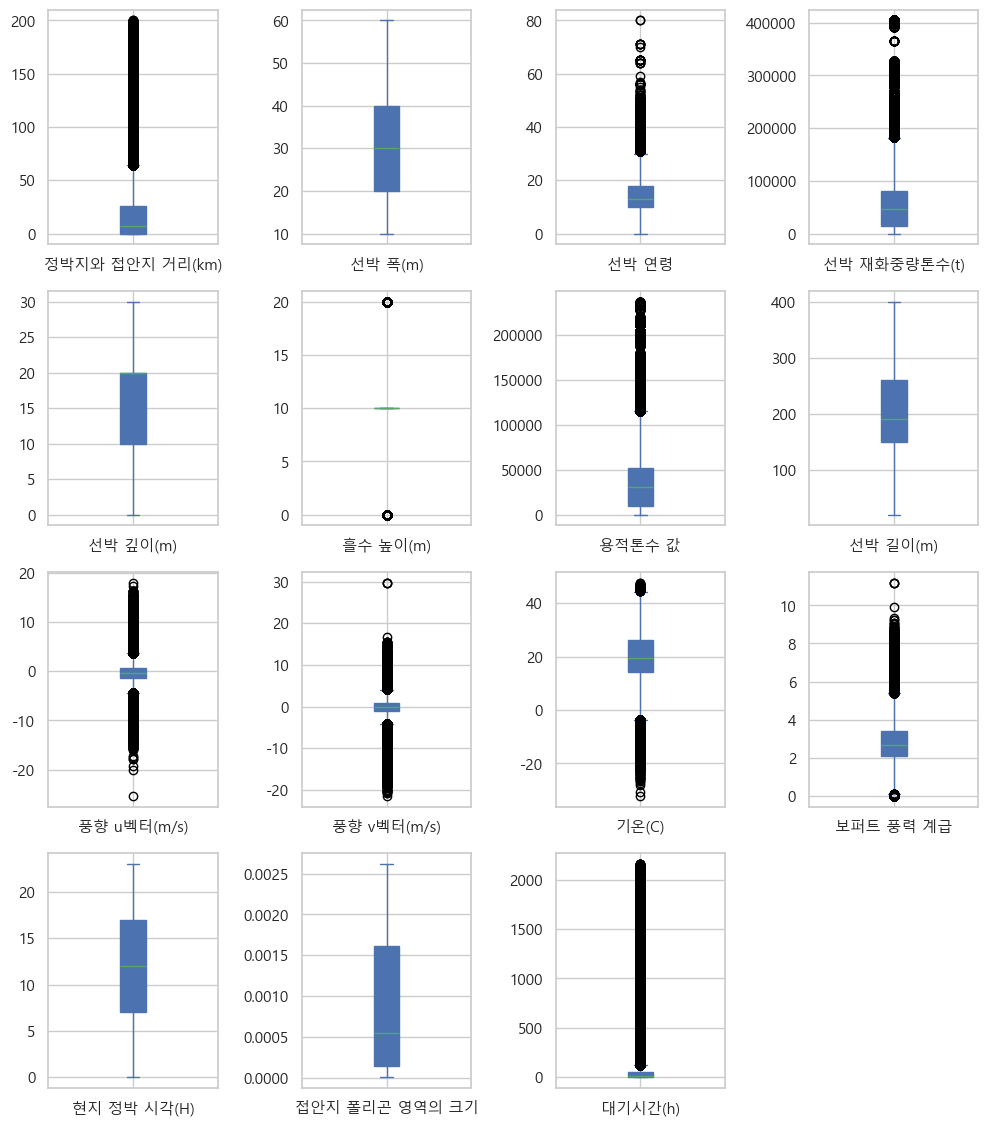

In [15]:
# subplots
df.plot(subplots=True, layout=(4,4), kind='box', figsize=(12,14), patch_artist=True)
plt.subplots_adjust(wspace=0.5)
plt.show();

In [16]:
ntnull = pd.read_csv('./data/train_notnull.csv')
ntnull

,SAMPLE_ID,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,...,LENGTH,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,CI_HOUR
0,TRAIN_000000,SG,GIW5,Container,30.881018,2018-12-17 21:29,Z618338,30.0,24,24300,...,180.0,CQSB78,Panama,-0.527582,-0.075277,27.637513,2.014493,5,0.002615,3.450000
1,TRAIN_000001,IN,UJM2,Bulk,0.000000,2014-09-23 6:59,X886125,30.0,13,35900,...,180.0,SPNO34,Marshall Islands,2.244962,0.213273,28.263135,3.102933,12,0.000217,0.000000
2,TRAIN_000002,CN,EUC8,Container,0.000000,2015-02-03 22:00,T674582,50.0,12,146000,...,370.0,FNPK22,Malta,-1.050854,-0.122173,17.651842,3.210685,6,0.001614,0.000000
3,TRAIN_000003,JP,ZAG4,Container,0.000000,2020-01-17 4:02,Y847238,20.0,18,6910,...,120.0,PBZV77,Bahamas,-3.180000,-1.610000,6.700000,2.629350,13,0.000356,0.000000
4,TRAIN_000004,SG,GIW5,Container,27.037650,2020-01-26 7:51,A872328,50.0,10,116000,...,300.0,GUCE76,Liberia,-0.330000,-3.280000,25.600000,2.495953,15,0.002615,253.554444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391928,TRAIN_391934,JP,QYY1,Container,0.000000,2017-06-06 5:02,Y375615,20.0,27,6820,...,110.0,KEJZ24,"China, People's Republic Of",0.836331,-0.767929,17.033054,2.157586,14,0.000552,0.000000
391929,TRAIN_391935,SG,GIW5,Bulk,5.884603,2019-10-16 0:36,K635567,10.0,12,3160,...,80.0,JLTM64,Vietnam,-0.660000,0.970000,27.300000,1.253491,8,0.002615,144.061389
391930,TRAIN_391936,US,QGN3,Bulk,70.660241,2021-03-23 22:35,J284147,30.0,8,60300,...,200.0,YERJ68,Singapore,-3.440000,7.990000,21.100000,4.766257,18,0.000155,41.482222
391931,TRAIN_391937,TW,JWI3,Container,9.448179,2015-01-08 7:15,J644215,30.0,29,23800,...,170.0,HCZK58,Comoros,-0.996649,-0.826293,25.702965,2.987039,15,0.000990,7.485278


<Axes: >

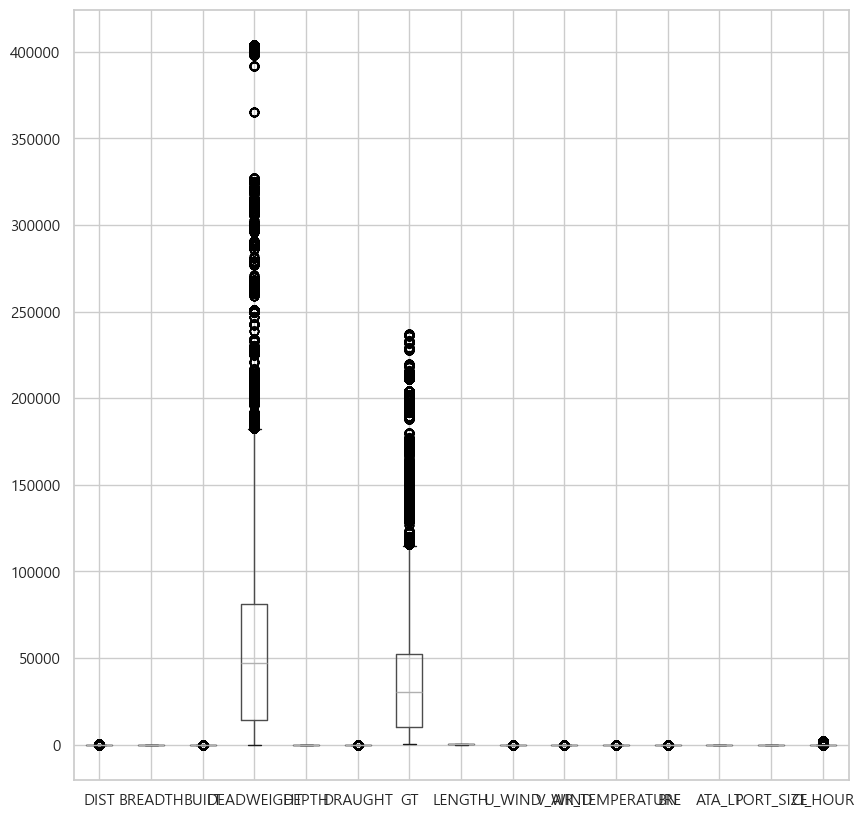

In [17]:
ntnull.boxplot()

In [18]:
q1, q3 = np.percentile(ntnull['BUILT'],[25,75])
q1, q3

(10.0, 18.0)

In [19]:
upper_bound = q3 + ((q3-q1) * 1.5)
upper_bound

30.0

In [20]:
ntnull.loc[ntnull['BUILT']>30, 'BUILT'] = upper_bound

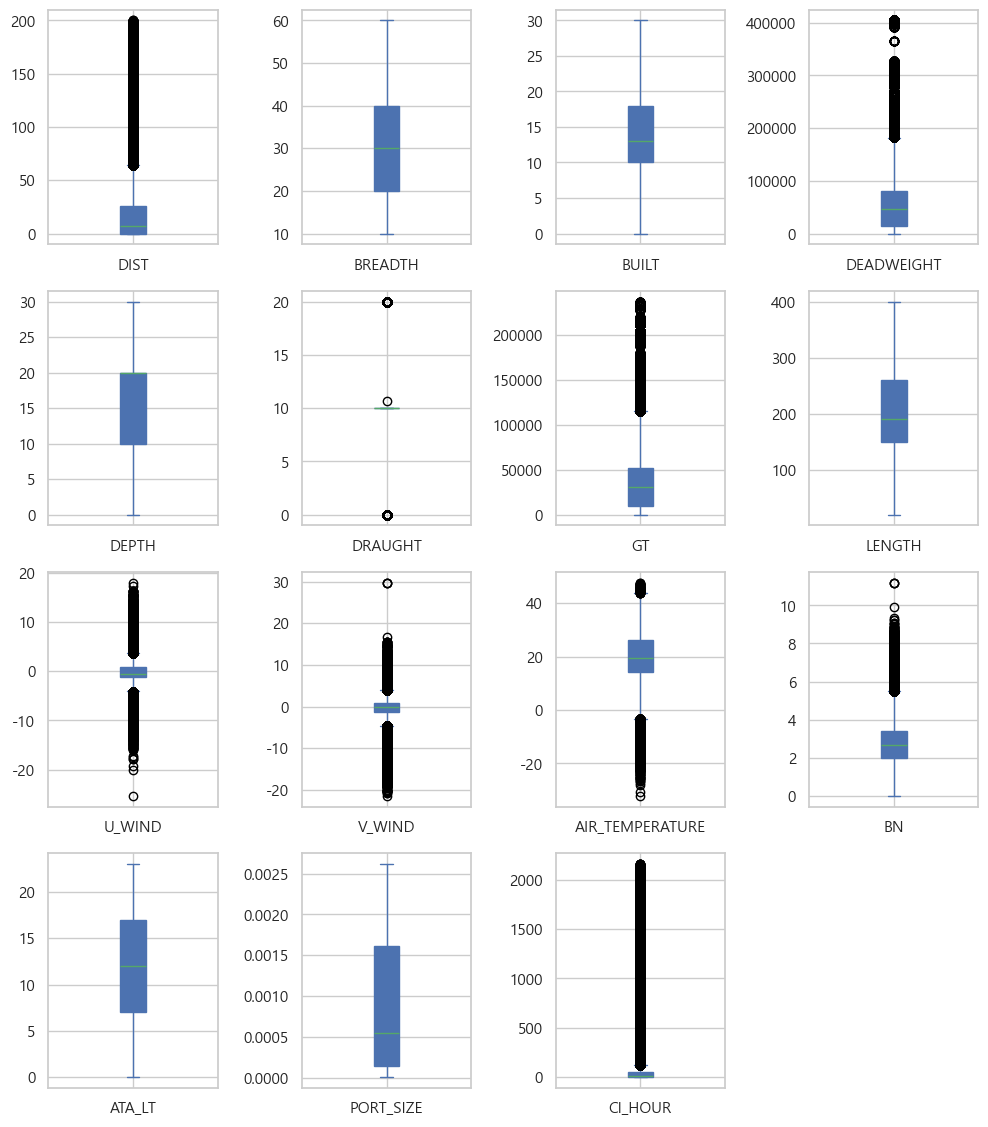

In [21]:
# subplots
ntnull.plot(subplots=True, layout=(4,4), kind='box', figsize=(12,14), patch_artist=True)
plt.subplots_adjust(wspace=0.5)
plt.show();

In [22]:
ntnull.to_csv('./data/train_notnull2.csv',index=False)

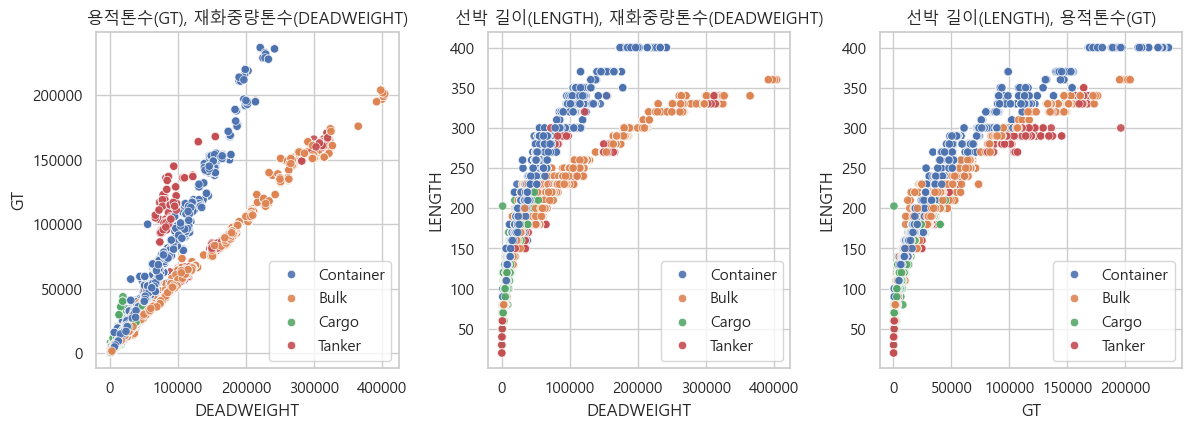

In [23]:
plt.figure(figsize=(16, 8))

plt.subplot(241)
sns.scatterplot(data=ntnull, x='DEADWEIGHT', y='GT', hue='SHIP_TYPE_CATEGORY', alpha=.9)
plt.title('용적톤수(GT), 재화중량톤수(DEADWEIGHT)')
plt.legend(loc='best')

plt.subplot(242)
sns.scatterplot(data=ntnull, x='DEADWEIGHT', y='LENGTH', hue='SHIP_TYPE_CATEGORY', alpha=.9)
plt.title('선박 길이(LENGTH), 재화중량톤수(DEADWEIGHT)')
plt.legend(loc='best')

plt.subplot(243)
sns.scatterplot(data=ntnull, x='GT', y='LENGTH', hue='SHIP_TYPE_CATEGORY', alpha=.9)
plt.title('선박 길이(LENGTH), 용적톤수(GT)')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

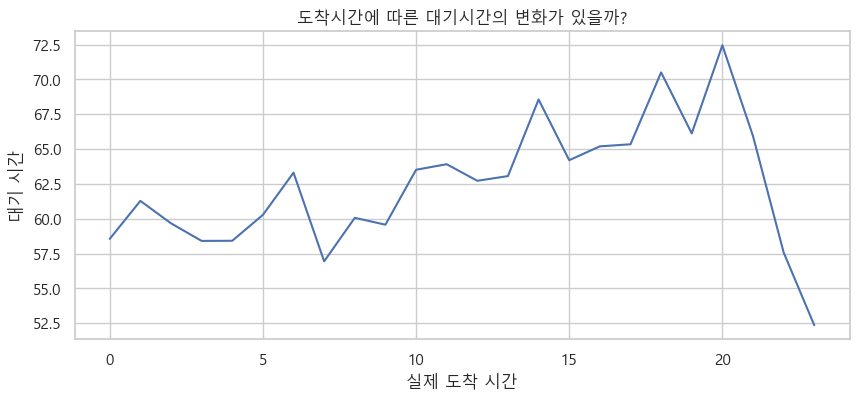

In [24]:
df_temp = ntnull.copy()

df_temp['ATA'] = pd.to_datetime(df_temp['ATA'])

df_temp['ATA_HOUR'] = df_temp['ATA'].apply(lambda x : int(x.strftime('%H')))

df_temp_1 = df_temp.groupby('ATA_HOUR')['CI_HOUR'].mean()

# 그래프
plt.figure(figsize=(10,4))

plt.plot(df_temp_1)
plt.xlabel('실제 도착 시간')
plt.ylabel('대기 시간')
plt.title('도착시간에 따른 대기시간의 변화가 있을까?')
plt.show()

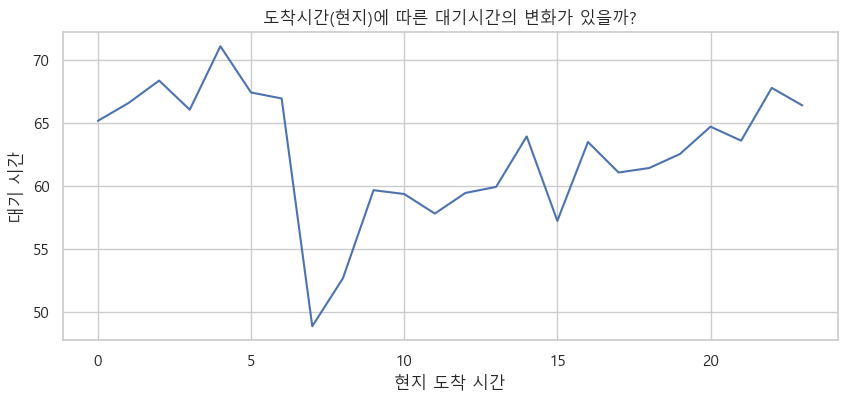

In [25]:
df_temp_2 = df_temp.groupby('ATA_LT')['CI_HOUR'].mean()

# 그래프
plt.figure(figsize=(10,4))

plt.plot(df_temp_2)
plt.xlabel('현지 도착 시간')
plt.ylabel('대기 시간')
plt.title('도착시간(현지)에 따른 대기시간의 변화가 있을까?')
plt.show()

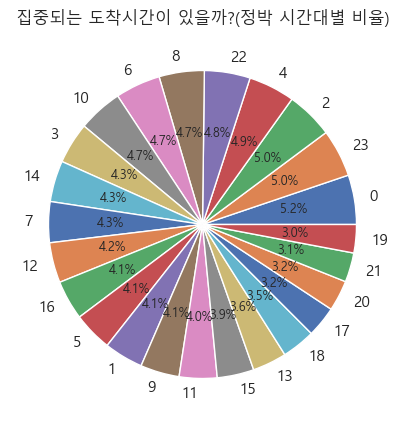

In [26]:
df_temp_1 = df_temp['ATA_HOUR'].value_counts()

# 그래프
plt.figure(figsize=(5,5))

plt.rcParams['font.size'] = 9
plt.pie(df_temp_1, labels = df_temp_1.index, autopct='%.1f%%')
plt.title('집중되는 도착시간이 있을까?(정박 시간대별 비율)')
plt.show()

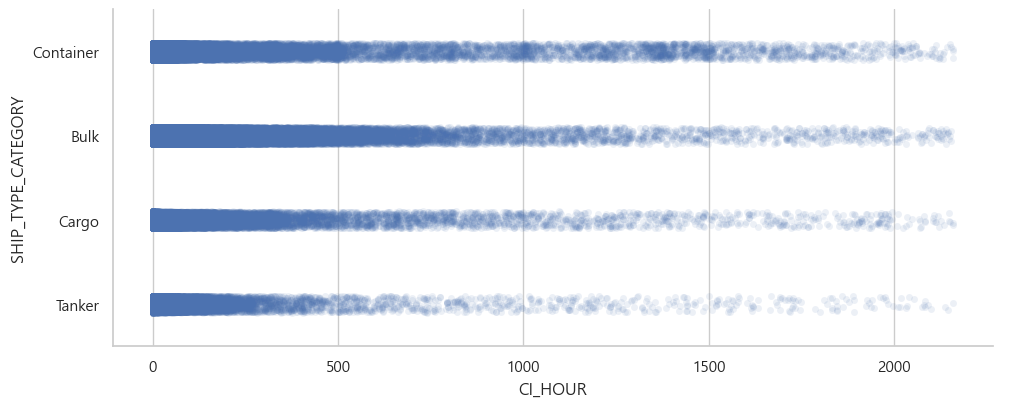

In [27]:
pl1 = sns.catplot(data=df_temp, x='CI_HOUR', y='SHIP_TYPE_CATEGORY', alpha=0.1)
pl1.figure.set_size_inches(12,4)

plt.show()

<Axes: title={'center': '선박 유형에 따른 평균 대기 시간'}, xlabel='선박유형', ylabel='평균 대기시간'>

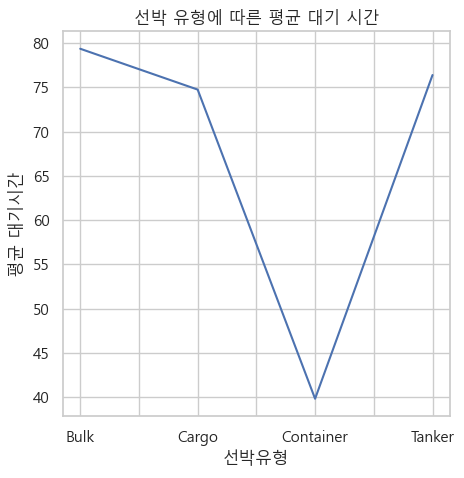

In [28]:
df_temp3 = df_temp.groupby(by='SHIP_TYPE_CATEGORY')['CI_HOUR'].mean()
df_temp3.plot(figsize=(5,5),title='선박 유형에 따른 평균 대기 시간',xlabel='선박유형', ylabel='평균 대기시간')

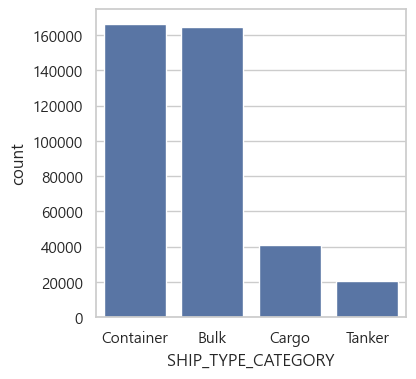

In [29]:
ax = sns.countplot(df_temp, x="SHIP_TYPE_CATEGORY")
ax.figure.set_size_inches(4,4)
plt.show()

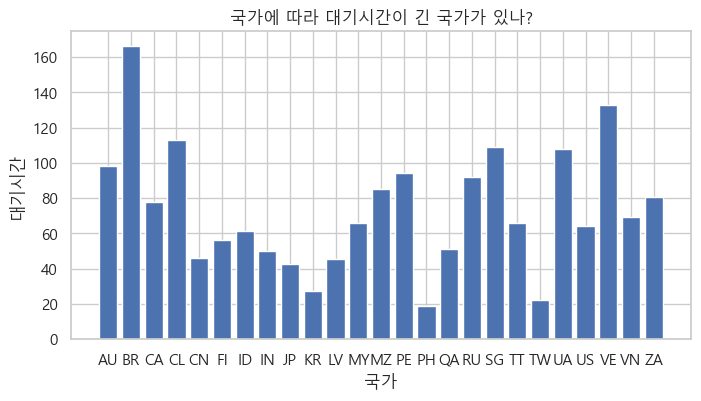

In [30]:
df_nation = df_temp.groupby('ARI_CO')['CI_HOUR'].mean()

# 인덱스 리스트로
label = df_nation.index
plt.figure(figsize=(8,4))

# 인덱스를 X, 평균 가격을 Y로 하는 막대 그래프 
plt.bar(label,df_nation)
plt.xlabel('국가')
plt.ylabel('대기시간')
plt.title('국가에 따라 대기시간이 긴 국가가 있나?')
plt.show()

In [31]:
df_temp=df_temp.drop(axis=1, columns='SAMPLE_ID')

In [32]:
df_temp.columns

Index(['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'DIST', 'ATA', 'ID',
       'BREADTH', 'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH',
       'SHIPMANAGER', 'FLAG', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN',
       'ATA_LT', 'PORT_SIZE', 'CI_HOUR', 'ATA_HOUR'],
      dtype='object')

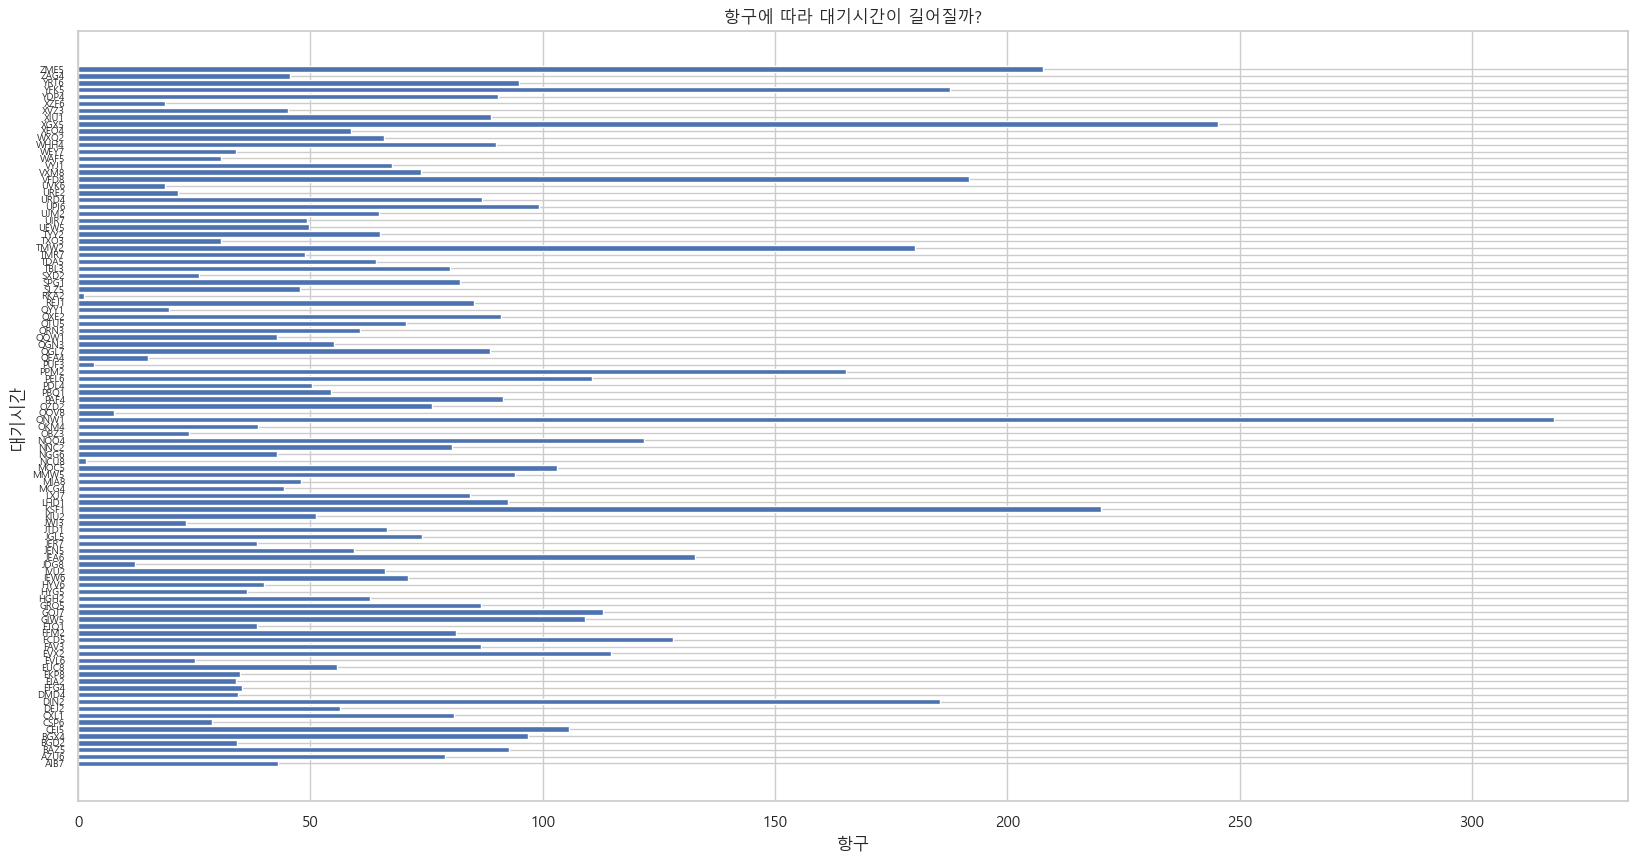

In [33]:
df_temp4 = df_temp.groupby(by='ARI_PO')['CI_HOUR'].mean()
# 인덱스 리스트로
label = df_temp4.index
plt.figure(figsize=(20,10))

# 인덱스를 X, 평균 가격을 Y로 하는 막대 그래프 
plt.barh(label,df_temp4)
plt.xlabel('항구')
plt.ylabel('대기시간')
plt.title('항구에 따라 대기시간이 길어질까?')
plt.yticks(size=7)
plt.show()

In [34]:
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    df_temp[feature] = le.fit_transform(df_temp[feature].astype(str))
    le_classes_set = set(le.classes_)
    # test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    # test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le


Encoding features: 100%|██████████| 6/6 [00:00<00:00, 10.97it/s]


In [35]:
df_temp=df_temp.drop(axis=1, columns='ATA_HOUR')

In [36]:
df_temp['year'] = df_temp['ATA'].dt.year
df_temp['month'] = df_temp['ATA'].dt.month
df_temp['day'] = df_temp['ATA'].dt.day
df_temp['hour'] = df_temp['ATA'].dt.hour
df_temp['minute'] = df_temp['ATA'].dt.minute
df_temp['weekday'] = df_temp['ATA'].dt.weekday

df_temp.drop(columns='ATA',inplace=True)

In [37]:
df_corr = df_temp.corr(method='spearman')
df_corr

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,...,BN,ATA_LT,PORT_SIZE,CI_HOUR,year,month,day,hour,minute,weekday
ARI_CO,1.000000,-0.258764,0.320481,-0.237020,-0.005332,-0.269902,0.115213,-0.346890,-0.253352,-0.278112,...,-0.174225,-0.014251,0.205084,-0.181452,0.096492,-0.015632,-0.000983,0.002479,0.029438,-0.046173
ARI_PO,-0.258764,1.000000,-0.172801,0.059995,0.010633,-0.023091,-0.029979,0.025316,-0.026095,0.037460,...,-0.068207,0.004033,-0.354305,0.065027,0.018976,0.011718,0.001118,0.006299,-0.005065,0.022652
SHIP_TYPE_CATEGORY,0.320481,-0.172801,1.000000,-0.108749,-0.001365,-0.242953,0.133550,-0.427143,-0.275973,-0.261513,...,-0.129249,-0.004849,0.523591,-0.228577,0.096159,-0.059914,0.001346,0.001656,0.071207,-0.056025
DIST,-0.237020,0.059995,-0.108749,1.000000,-0.003293,0.069875,-0.021344,0.097845,0.050011,0.099034,...,-0.002686,-0.005213,0.081873,0.818395,0.040900,-0.010243,0.003613,0.006874,0.003511,0.129770
ID,-0.005332,0.010633,-0.001365,-0.003293,1.000000,-0.004258,-0.001144,-0.003763,-0.006679,0.001066,...,-0.011545,0.000481,-0.005578,-0.004878,-0.005221,-0.000096,0.001476,-0.001531,-0.000891,-0.001789
BREADTH,-0.269902,-0.023091,-0.242953,0.069875,-0.004258,1.000000,-0.181561,0.919080,0.793701,0.714722,...,0.132928,0.007679,-0.035128,0.059220,-0.210809,0.010357,-0.003247,-0.013100,-0.050806,0.013048
BUILT,0.115213,-0.029979,0.133550,-0.021344,-0.001144,-0.181561,1.000000,-0.218003,-0.182167,-0.136825,...,-0.016122,-0.007781,0.092551,-0.034167,-0.131919,-0.001136,-0.000144,0.010379,-0.025228,-0.013879
DEADWEIGHT,-0.346890,0.025316,-0.427143,0.097845,-0.003763,0.919080,-0.218003,1.000000,0.858619,0.722841,...,0.149956,0.009144,-0.150570,0.118959,-0.208414,0.017406,-0.003093,-0.013408,-0.051839,0.026689
DEPTH,-0.253352,-0.026095,-0.275973,0.050011,-0.006679,0.793701,-0.182167,0.858619,1.000000,0.542128,...,0.117103,0.006337,-0.041154,0.054703,-0.174427,0.010893,-0.003622,-0.004987,-0.045848,0.010001
DRAUGHT,-0.278112,0.037460,-0.261513,0.099034,0.001066,0.714722,-0.136825,0.722841,0.542128,1.000000,...,0.136117,0.007158,-0.093274,0.099561,-0.159667,0.010994,-0.003860,-0.022739,-0.037614,0.022332


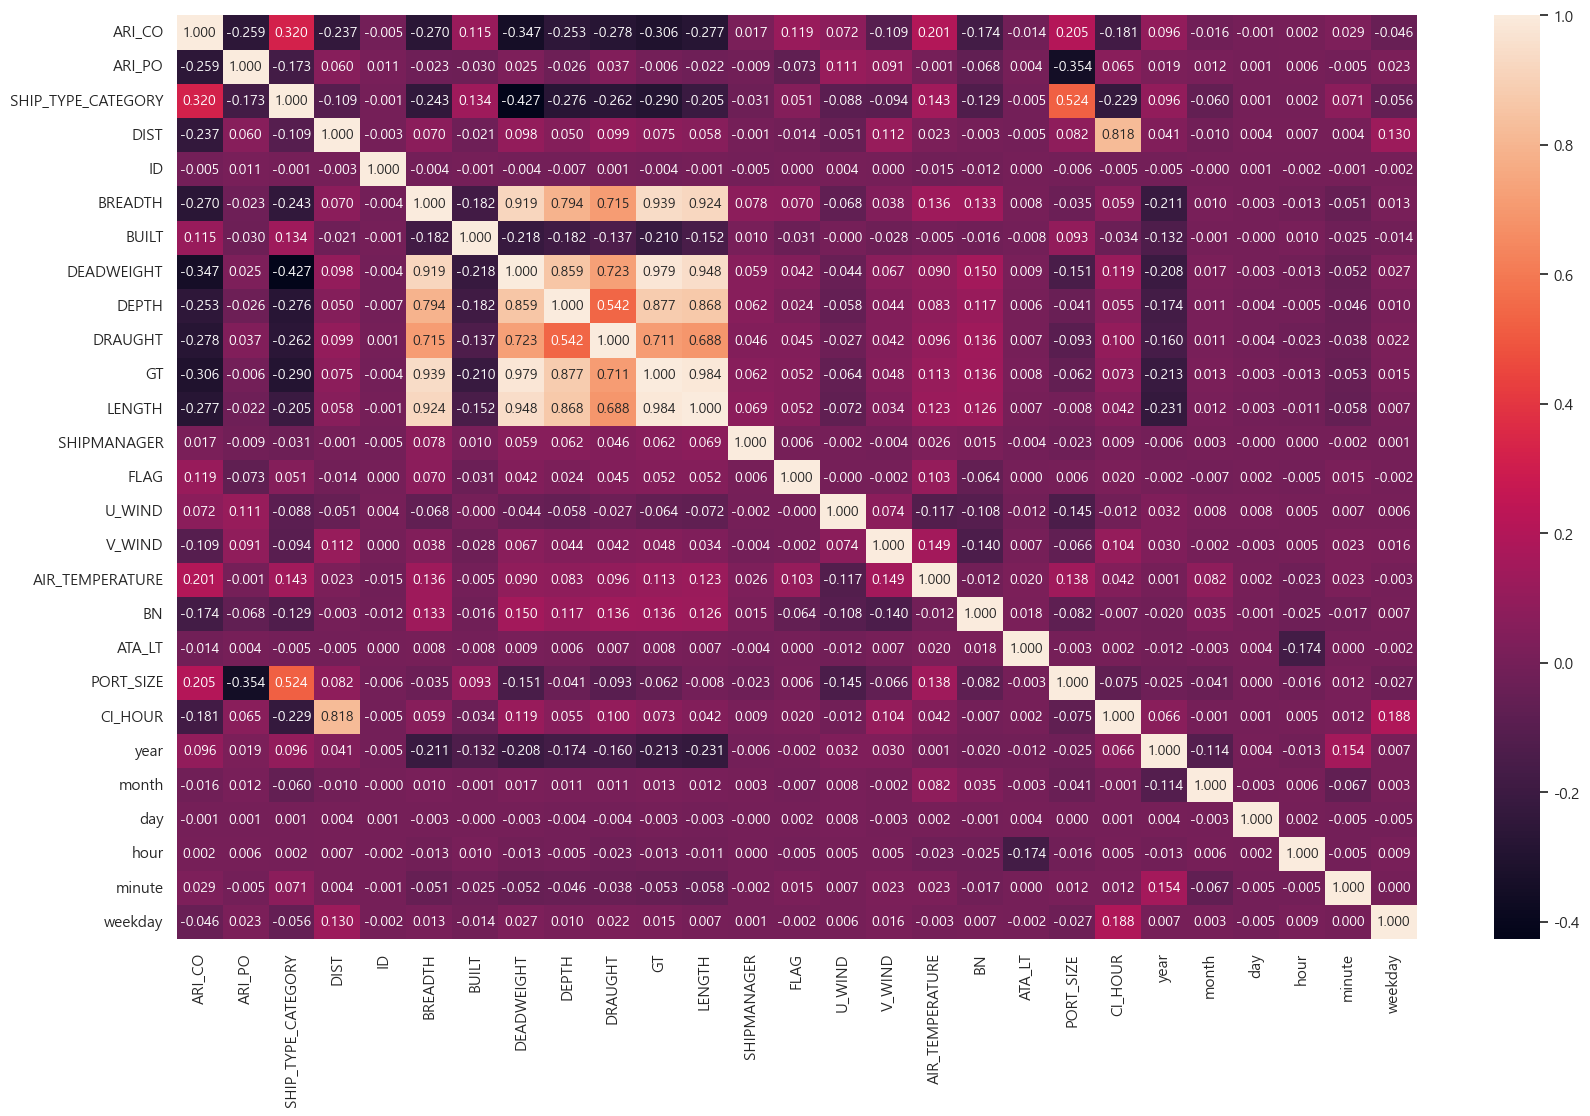

In [38]:
plt.figure(figsize=(20,12))
sns.heatmap(df_corr,annot=True, fmt='.3f',annot_kws={'size':10})
plt.savefig('heatmap.png',bbox_inches='tight')

In [39]:
df_corr = df_temp.corr(method='pearson')
df_corr

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,...,BN,ATA_LT,PORT_SIZE,CI_HOUR,year,month,day,hour,minute,weekday
ARI_CO,1.000000,-0.324990,0.293219,-0.204145,-0.012398,-0.164861,0.103520,-0.262027,-0.164803,-0.191689,...,-0.090879,-0.017555,0.285941,0.005221,0.064886,-0.014665,-0.001214,0.001031,0.025193,-0.046788
ARI_PO,-0.324990,1.000000,-0.207363,0.003832,0.011500,-0.009616,-0.029345,0.120793,-0.020808,0.050305,...,-0.043338,0.004061,-0.443317,-0.000825,0.025664,0.013775,0.000978,0.005160,-0.004728,0.027524
SHIP_TYPE_CATEGORY,0.293219,-0.207363,1.000000,0.051674,-0.001181,-0.220395,0.113844,-0.399052,-0.258906,-0.261667,...,-0.102274,-0.003822,0.511171,-0.087106,0.094207,-0.061093,0.001448,0.001500,0.072221,-0.064567
DIST,-0.204145,0.003832,0.051674,1.000000,-0.001614,0.025350,-0.004782,0.025490,-0.001037,0.031941,...,-0.035524,-0.000011,0.191330,0.189144,0.019026,-0.018919,0.004719,-0.001206,-0.001053,0.106292
ID,-0.012398,0.011500,-0.001181,-0.001614,1.000000,-0.002030,-0.003956,-0.002408,-0.003721,0.000993,...,-0.011252,0.000457,-0.009413,-0.008185,-0.005750,-0.000100,0.001459,-0.001447,-0.000893,-0.002197
BREADTH,-0.164861,-0.009616,-0.220395,0.025350,-0.002030,1.000000,-0.204533,0.857126,0.790474,0.761335,...,0.102312,0.005998,0.036766,0.043705,-0.198405,0.008747,-0.003403,-0.016025,-0.047615,0.015075
BUILT,0.103520,-0.029345,0.113844,-0.004782,-0.003956,-0.204533,1.000000,-0.241026,-0.202256,-0.144055,...,-0.017766,-0.008506,0.048766,-0.004259,-0.126773,0.000778,-0.000311,0.010627,-0.024962,-0.010784
DEADWEIGHT,-0.262027,0.120793,-0.399052,0.025490,-0.002408,0.857126,-0.241026,1.000000,0.712964,0.813403,...,0.113472,0.007765,-0.138995,0.077950,-0.132251,0.017610,-0.003382,-0.019403,-0.031281,0.041477
DEPTH,-0.164803,-0.020808,-0.258906,-0.001037,-0.003721,0.790474,-0.202256,0.712964,1.000000,0.581058,...,0.087723,0.004849,0.019597,0.051755,-0.169622,0.012085,-0.003949,-0.005892,-0.047835,0.010653
DRAUGHT,-0.191689,0.050305,-0.261667,0.031941,0.000993,0.761335,-0.144055,0.813403,0.581058,1.000000,...,0.105171,0.005970,-0.043581,0.040308,-0.161707,0.010639,-0.003784,-0.023224,-0.038097,0.026767


<Axes: >

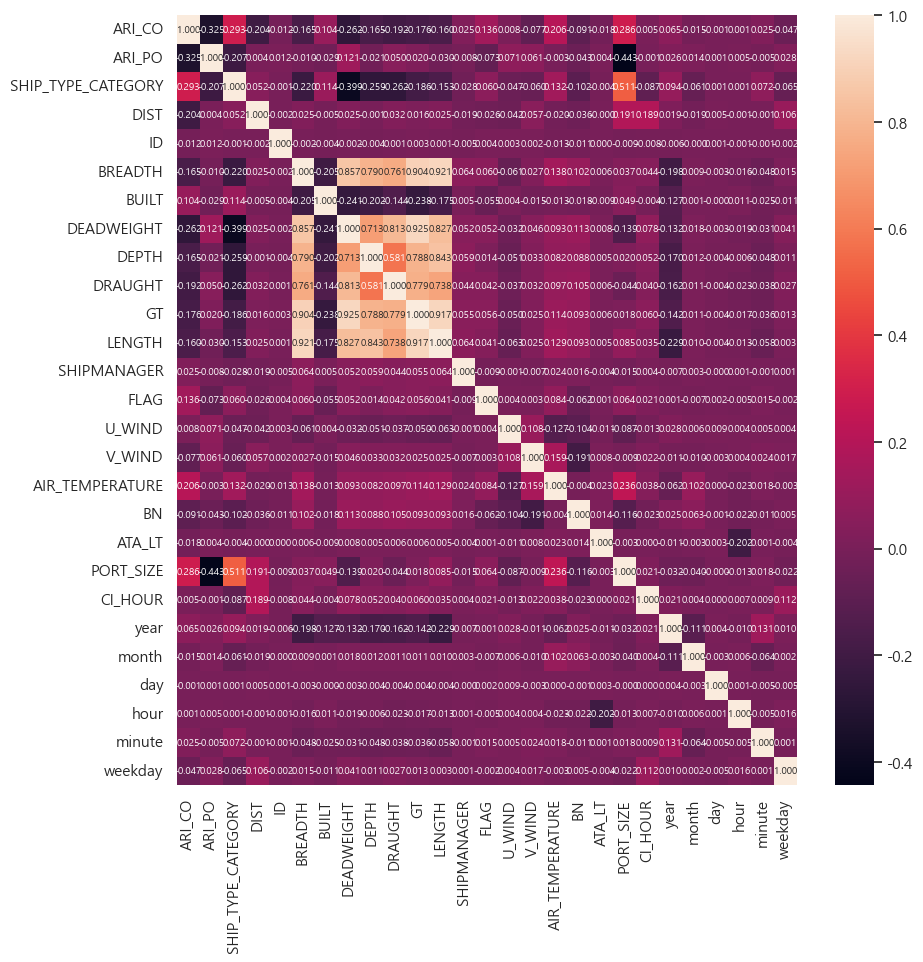

In [40]:
sns.heatmap(df_corr,annot=True, fmt='.3f',annot_kws={'size':7})

In [41]:
df_temp.drop(columns=['ID', 'SHIPMANAGER', 'BN', 'ATA_LT', 'month', 'day', 'hour', 'minute'],inplace=True)

In [42]:
df_temp.to_csv('./data/train_notnull_usecols.csv')

## 참고자료

https://github.com/LeticiaKang/HYUNDAE_AI_Challenge_DACON/blob/main/(%EB%8D%B0%EC%9D%B4%ED%84%B0%20%EB%B3%80%EA%B2%BD%20%ED%9B%84)%EB%8D%B0%EC%9D%B4%ED%84%B0%20%ED%83%90%EC%83%89%20%EB%B0%8F%20%EC%A0%84%EC%B2%98%EB%A6%AC(1).ipynb
